In [1]:
import openai
from openai import OpenAI
from dotenv import load_dotenv
import os
import pandas as pd
from IPython.display import Image

In [2]:
# https://platform.openai.com/docs/assistants/overview
# https://platform.openai.com/docs/assistants/tools

In [3]:
# Load API key from .env

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

In [4]:
# Files for assistant to use

file1 = client.files.create(
  file=open("./data/PlayerStats.csv", "rb"),
  purpose='assistants'
)
print(file1)

file2 = client.files.create(
  file=open("./data/Games.csv", "rb"),
  purpose='assistants'
)
print(file2)

FileObject(id='file-K4yafLZgdNRAlfwH5FV004Ry', bytes=15658018, created_at=1704442230, filename='PlayerStats.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-KlVaIyIQOiG0km0yStpoW7m8', bytes=993779, created_at=1704442230, filename='Games.csv', object='file', purpose='assistants', status='processed', status_details=None)


In [5]:
# Create or import assistant

assistant = client.beta.assistants.create(
    name="Machine Learning Buddy Template",
    model="gpt-4-1106-preview",
    instructions="""
    You are a data analyst and machine learning expert. Write and run code
    to analyze the csv files you have based on the users requests and provide
    summaries of your analysis and code blocks of how to do what you did.
    """,
    tools=[{"type": "code_interpreter"}],
    file_ids=[file1.id, file2.id],
)
assistant

Assistant(id='asst_mfT6dEiKJ8eISOsnQQbSgZ0A', created_at=1704442234, description=None, file_ids=['file-K4yafLZgdNRAlfwH5FV004Ry', 'file-KlVaIyIQOiG0km0yStpoW7m8'], instructions='\n    You are a data analyst and machine learning expert. Write and run code\n    to analyze the csv files you have based on the users requests and provide\n    summaries of your analysis and code blocks of how to do what you did.\n    ', metadata={}, model='gpt-4-1106-preview', name='Machine Learning Buddy Template', object='assistant', tools=[ToolCodeInterpreter(type='code_interpreter')])

In [6]:
# Create thread

thread = client.beta.threads.create()

In [7]:
# Add message to thread

user_message = """
Who are the best performing wide receivers so far this season and statistics of them? Then make 
me a visualization of it and give it to me to download. Only give me a maximum of one image_file
to download at the end.
"""
# user_message = "Can you visualize that for me in a beautiful and insightful way now and give me it to download"
# user_message = "Now make me a more advanced visualization I can view in a jupyter notebook of the data with different software"

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message
)

In [8]:
# Run it 

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)
run

Run(id='run_CQJdD1j761uvJhCcDpSt1oZY', assistant_id='asst_mfT6dEiKJ8eISOsnQQbSgZ0A', cancelled_at=None, completed_at=None, created_at=1704442245, expires_at=1704442845, failed_at=None, file_ids=['file-K4yafLZgdNRAlfwH5FV004Ry', 'file-KlVaIyIQOiG0km0yStpoW7m8'], instructions='\n    You are a data analyst and machine learning expert. Write and run code\n    to analyze the csv files you have based on the users requests and provide\n    summaries of your analysis and code blocks of how to do what you did.\n    ', last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=None, started_at=None, status='queued', thread_id='thread_GK1TbRUBNdL8d3BKc8BQkI20', tools=[ToolAssistantToolsCode(type='code_interpreter')])

In [10]:
# Check run status
# status='completed' when the model is done processing
# status='in_progress' model still processing

run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)
run

Run(id='run_CQJdD1j761uvJhCcDpSt1oZY', assistant_id='asst_mfT6dEiKJ8eISOsnQQbSgZ0A', cancelled_at=None, completed_at=1704442377, created_at=1704442245, expires_at=None, failed_at=None, file_ids=['file-K4yafLZgdNRAlfwH5FV004Ry', 'file-KlVaIyIQOiG0km0yStpoW7m8'], instructions='\n    You are a data analyst and machine learning expert. Write and run code\n    to analyze the csv files you have based on the users requests and provide\n    summaries of your analysis and code blocks of how to do what you did.\n    ', last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=None, started_at=1704442245, status='completed', thread_id='thread_GK1TbRUBNdL8d3BKc8BQkI20', tools=[ToolAssistantToolsCode(type='code_interpreter')])

In [11]:
# Retreive and print messages details

messages = client.beta.threads.messages.list(
  thread_id=thread.id
)
messages

SyncCursorPage[ThreadMessage](data=[ThreadMessage(id='msg_F4PcsGNM7nOIZljXhxRhEmxE', assistant_id='asst_mfT6dEiKJ8eISOsnQQbSgZ0A', content=[MessageContentImageFile(image_file=ImageFile(file_id='file-DtMfhT6GgfZbSwPM6iLtEr9N'), type='image_file'), MessageContentText(text=Text(annotations=[TextAnnotationFilePath(end_index=377, file_path=TextAnnotationFilePathFilePath(file_id='file-63kR46kHRn4J0SRXFLrNF6Ym'), start_index=333, text='sandbox:/mnt/data/top_WR_receiving_yards.png', type='file_path')], value='I have created a visualization of the top 10 wide receivers sorted by their receiving yards. The bar plot shows the receiving yards for each wide receiver on the x-axis and the player names on the y-axis.\n\nYou can download the visualization from the following link:\n\n[Download Top 10 Wide Receivers by Receiving Yards Visualization](sandbox:/mnt/data/top_WR_receiving_yards.png)'), type='text')], created_at=1704442374, file_ids=['file-63kR46kHRn4J0SRXFLrNF6Ym'], metadata={}, object='thre

In [12]:
# Retreive and print last message 

messages = client.beta.threads.messages.list(
  thread_id=thread.id
)
messages.data[0].content[0]

MessageContentImageFile(image_file=ImageFile(file_id='file-DtMfhT6GgfZbSwPM6iLtEr9N'), type='image_file')

In [13]:
# Check for file images or other files created

messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

# content = messages.data[0].content[0]
file_downloaded_id = messages.data[0].content[0]

# Check for image file's file_id
if hasattr(file_downloaded_id, 'image_file'):
    print('Image found')
# Check for text file's annotations file_id
elif hasattr(file_downloaded_id, 'text') and hasattr(file_downloaded_id.text, 'annotations'):
    print('Other file found, hmmmmm.. ')
else:
    print('No image or text file found')

Image found


In [14]:
# Retreive and print all messages

messages = client.beta.threads.messages.list(
  thread_id=thread.id
)
for message in reversed(messages.data):
    if hasattr(message.content[0], 'text'):
        print(message.role + ": " + message.content[0].text.value)
    elif hasattr(message.content[0], 'image_file'):
        print(message.role + ": [Image file received]")

user: 
Who are the best performing wide receivers so far this season and statistics of them? Then make 
me a visualization of it and give it to me to download. Only give me a maximum of one image_file
to download at the end.

assistant: To answer your question, I will first need to check the contents of the CSV files you uploaded to see if they contain the necessary information about wide receivers and their performance statistics for the season. Let's start by loading the data from both CSV files and examining their contents to identify which one contains the information we need to analyze the performance of wide receivers.

I will load the files, display the first few rows of each, and look for any columns that might relate to wide receivers and their statistics.
assistant: It appears that both CSV files have been loaded successfully, but unfortunately, I cannot display the contents directly to you. My next step is to look for relevant information that identifies football wide receiv

Image found


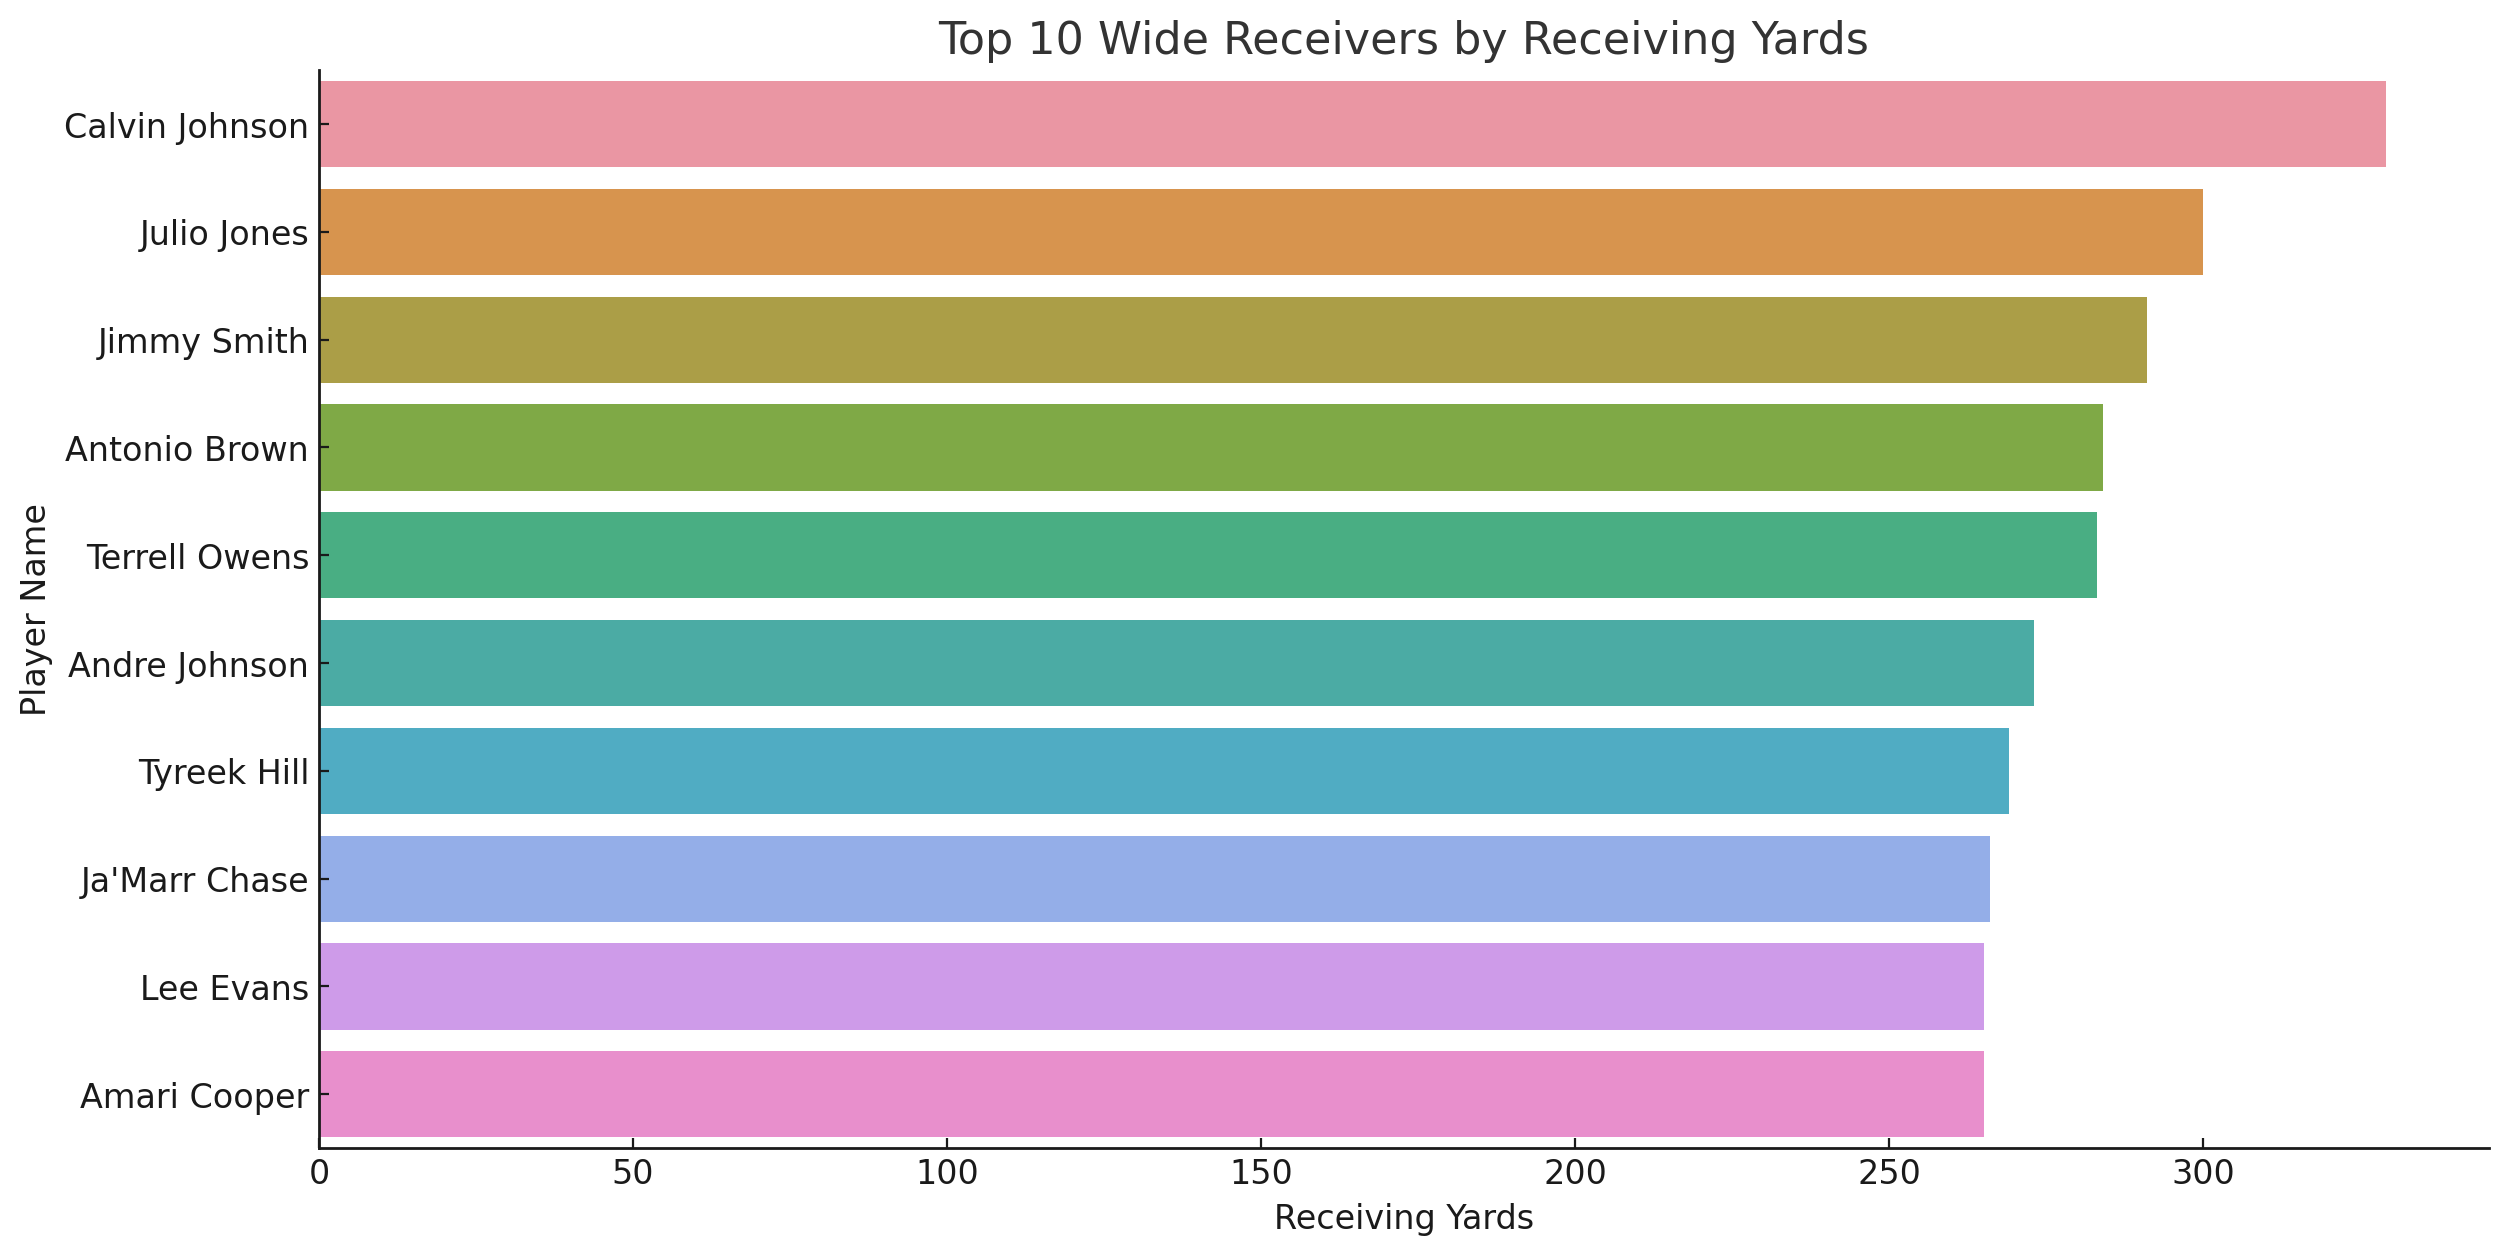

In [15]:
# Download and display image

messages = client.beta.threads.messages.list(
  thread_id=thread.id
)
file_downloaded_id = messages.data[0].content[0]

# Check for image file's file_id
if hasattr(file_downloaded_id, 'image_file'):
    print('Image found')
    image_data = client.files.content(messages.data[0].content[0].image_file.file_id)
    image_data_bytes = image_data.read()
    
    with open("./data/image.png", "wb") as file:
        file.write(image_data_bytes)

    display(Image(filename="./data/image.png"))
    
else:
    print('No image or text file found')

In [16]:
# Input and output logs of code interpreter

run_steps = client.beta.threads.runs.steps.list(
  thread_id=thread.id,
  run_id=run.id
)
run_steps

SyncCursorPage[RunStep](data=[RunStep(id='step_D1FIZDhoZrp2vefAfaxopIPr', assistant_id='asst_mfT6dEiKJ8eISOsnQQbSgZ0A', cancelled_at=None, completed_at=1704442377, created_at=1704442374, expired_at=None, failed_at=None, last_error=None, metadata=None, object='thread.run.step', run_id='run_CQJdD1j761uvJhCcDpSt1oZY', status='completed', step_details=MessageCreationStepDetails(message_creation=MessageCreation(message_id='msg_F4PcsGNM7nOIZljXhxRhEmxE'), type='message_creation'), thread_id='thread_GK1TbRUBNdL8d3BKc8BQkI20', type='message_creation', expires_at=None), RunStep(id='step_d8jPWITUf9cEJRg561zPKBWu', assistant_id='asst_mfT6dEiKJ8eISOsnQQbSgZ0A', cancelled_at=None, completed_at=1704442374, created_at=1704442344, expired_at=None, failed_at=None, last_error=None, metadata=None, object='thread.run.step', run_id='run_CQJdD1j761uvJhCcDpSt1oZY', status='completed', step_details=ToolCallsStepDetails(tool_calls=[CodeToolCall(id='call_mbMAT9u2TbNqGDPOz0zZnhtI', code_interpreter=CodeInterpret